In [2]:
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob
import numpy as np
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.ndimage.measurements import label
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML

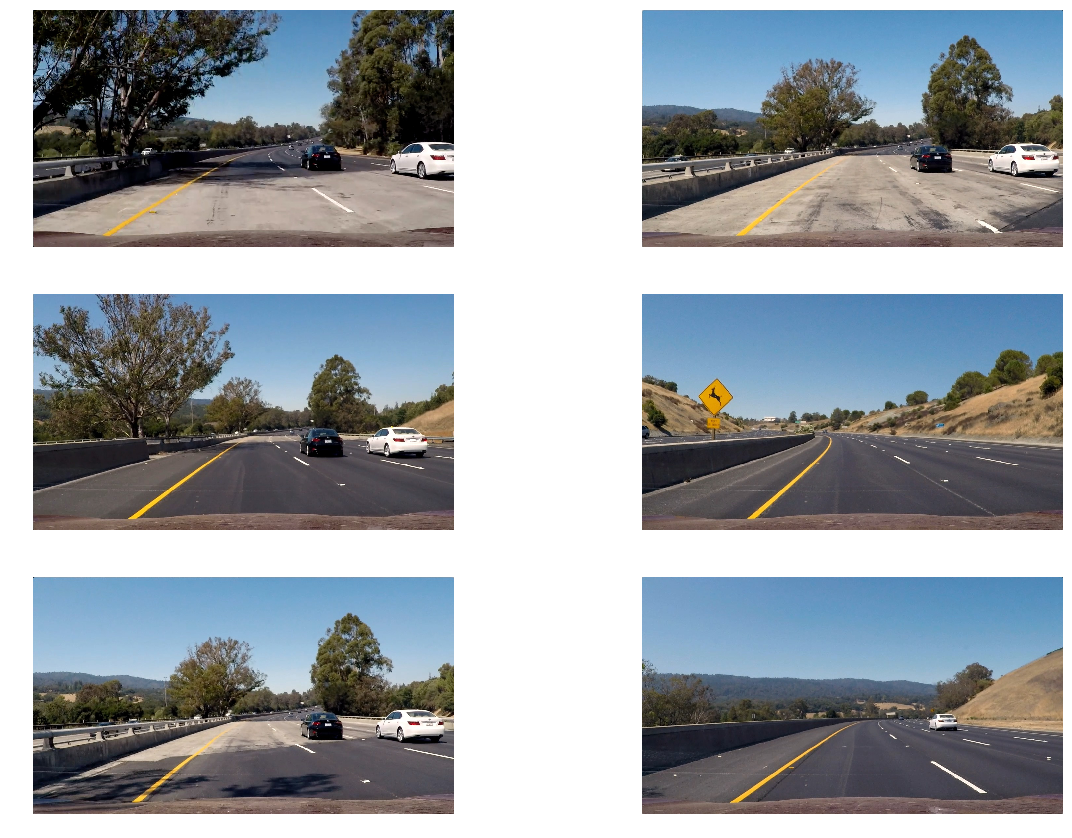

In [3]:
test_imgs   = glob.glob('./test_images/*.jpg')
counter =1
plt.figure(figsize=(20,20))
for i in test_imgs:
    img = mpimg.imread(i)
    plt.subplot(4,2,counter)
    plt.imshow(img)
    plt.axis("off")
    counter+=1
plt.show()

In [4]:
##### DATA PROPERTIES #####
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    car_img = mpimg.imread(car_list[0])
    data_dict["image_shape"] = car_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = car_img.dtype
    # Return data_dict
    return data_dict


Number of car images: 8792
Number of non car images: 8968
Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


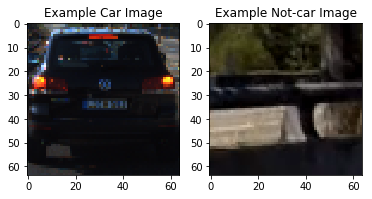

In [5]:
#### READ TRAINING DATA #####
cars   = glob.glob('./vehicles/**/*.png')
notcars= glob.glob('./non-vehicles/**/*.png')

print("Number of car images: {}".format(len(cars)))
print("Number of non car images: {}".format(len(notcars)))
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

In [6]:
##### COVERT COLOR SPACE #####
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)


In [7]:
##### HOG FEATURES ######
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True, 
                     feature_vec=True):
    
    results = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=vis, feature_vector=feature_vec)#,
#                           block_norm="L2-Hys")
    if(vis):
        return results[0], results[1]
    return results
    

In [8]:
###### COLOR HISTOGRAM #####
def color_hist(img, nbins=32, bins_range=(0, 256)):
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    return rhist, ghist, bhist, bin_centers, hist_features

In [9]:
##### EXTRACT FEATURES ######
def extract_features(imgs, cspace='RGB',orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel="ALL",spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 1)):
    # Create a list to append feature vectors to
    features = []
    for i in tqdm(imgs):
        img = mpimg.imread(i)
        if cspace != 'RGB':
            feature_image = convert_color(img, conv = "RGB2YCrCb")
        else: feature_image = np.copy(img) 
        if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        color_hist_res = color_hist(feature_image,hist_bins,hist_range)
        new_features = np.concatenate((color_hist_res[4],hog_features ))
        features.append(new_features)
    return features

In [34]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12
pix_per_cell = 10
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
histbin = 32
spatial = 32

t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256))



100%|██████████| 8968/8968 [00:42<00:00, 208.59it/s]


In [35]:
print(car_features[0].shape)
print(car_features[0].dtype)
print()
print(len(car_features))
print(len(notcar_features))

(3696,)
float64

8792
8968


In [36]:
###### TRAIN THE MODEL ######
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)  
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)
    print(X_train[0].shape)
    # Fit a per-column scaler only on the training data
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X_train and X_test
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    print('Using spatial binning of:',spatial,
        'and', histbin,'histogram bins')
    print('Feature vector length:', len(X_train[0]))
    print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
else: 
    print('Your function only returns empty feature vectors...')

(3696,)
Using spatial binning of: 32 and 32 histogram bins
Feature vector length: 3696
Using: 12 orientations 10 pixels per cell and 2 cells per block
Feature vector length: 3696
13.36 Seconds to train SVC...
Test Accuracy of SVC =  0.9811
My SVC predicts:  [ 0.  0.  1.  0.  0.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  0.  1.  1.  0.  1.]
0.00192 Seconds to predict 10 labels with SVC


In [37]:
###### SAVE TO PICKLE FILE #####
svc_pickle = {}
svc_pickle["svc"] = svc
svc_pickle["scaler"] = X_scaler
svc_pickle["orient"] = orient
svc_pickle["pix_per_cell"] = pix_per_cell
svc_pickle["cell_per_block"] = cell_per_block
svc_pickle["spatial_size"] = spatial
svc_pickle["hist_bins"] = histbin
svc_pickle["colorspace"] = colorspace
svc_pickle["hog_channel"] = hog_channel
pickle.dump( svc_pickle, open( "./svc_pickle.p", "wb" ) )


In [10]:
###### DRAW BOUNDING BOX ######

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [11]:
bound_box = []

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,xstart):
    box_lst = []
    draw_img = np.copy(img)
    image_shape = img.shape
    img = img.astype(np.float32)/255
#     img_tosearch=img[:, xstart:xstop,:]
    img_tosearch = img[ystart:ystop,xstart:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis = False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis = False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis = False, feature_vec=False)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            f=[]
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            hist_features = color_hist(subimg, nbins=hist_bins)

            test_features = X_scaler.transform(np.hstack((hist_features[4], hog_features)).reshape(1, -1)) 
            
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xstart + xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box_lst.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return box_lst
    

In [12]:
# load a pe-trained svc model from a serialized (pickle) file
svc_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
# get attributes of our svc object
svc = svc_pickle["svc"]
X_scaler = svc_pickle["scaler"]
orient = svc_pickle["orient"]
pix_per_cell = svc_pickle["pix_per_cell"]
cell_per_block = svc_pickle["cell_per_block"]
spatial_size = svc_pickle["spatial_size"]
hist_bins = svc_pickle["hist_bins"]
color_space = svc_pickle["colorspace"]
hog_channel = svc_pickle["hog_channel"]

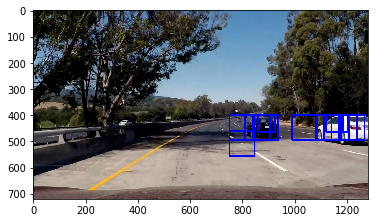

In [13]:
ystart = [380,400,472,496,504]
ystop =[476,560,560,656,672]
scale = [1,1.5,2,2.5,3]
xstart = 600


bbox_lst1 =[]
img = mpimg.imread(test_imgs[0])
for i in range(len(scale)):
    bbox_lst = find_cars(img, ystart[i], ystop[i], scale[i], svc, X_scaler, orient, pix_per_cell, cell_per_block,xstart)
    bbox_lst1.append(bbox_lst)

bbox_lst1 = [item for sublist in bbox_lst1 for item in sublist]
out_img = draw_boxes(img,bbox_lst1)
plt.imshow(out_img)
plt.show()


In [14]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        
    # Return the image
    return img


In [15]:
heatmaps=[]
def sumheat(heatmap):
    global heatmaps
    if (len(heatmaps)<10):
        heatmaps.append(heatmap)
        return heatmap
    heatmaps.append(heatmap)
    heatmaps=heatmaps[-10:]
    heat_sum=np.zeros_like(heatmap)
    for i in range(10):
        heat_sum= heatmaps[i]+heat_sum
    
    return heat_sum

In [16]:
# Add heat to each box in box list

def heatmap(img,boxes):
    global flag 
    heat = np.zeros_like(img[:,:,0])
    
    heat = add_heat(heat,boxes)
    
    if(np.max(heat)>=1):
        flag=1
    if(flag == 1):
        heat = sumheat(heat)
        
    heat_thresh = apply_threshold(heat,5)
    
    heatmap = np.clip(heat_thresh, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return heat,heat_thresh, draw_img


In [17]:
ystart = [380,400,472,496,504]
ystop =[476,560,560,656,672]
scale = [1,1.5,2,2.5,3]
xstart = 600
flag =0
def PipelineForVideo(img):
    bbox_lst1=[]
    for i in range(len(scale)):
        bbox_lst = find_cars(img, ystart[i], ystop[i], scale[i], svc, X_scaler, orient, pix_per_cell, cell_per_block,xstart)
        bbox_lst1+=bbox_lst
    res_img = heatmap(img,bbox_lst1)
    return res_img

In [15]:

if os.path.isdir("test_video_output"):
    pass
else:
    os.mkdir("test_video_output")

white_output = "./test_video_output/project_video_output_heat5_avg10.mp4"
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(PipelineForVideo) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
clip1.reader.close()

[MoviePy] >>>> Building video ./test_video_output/project_video_output_heat5_avg10.mp4
[MoviePy] Writing video ./test_video_output/project_video_output_heat5_avg10.mp4


100%|█████████▉| 1260/1261 [05:51<00:00,  3.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_output/project_video_output_heat5_avg10.mp4 

CPU times: user 5min 9s, sys: 30.7 s, total: 5min 39s
Wall time: 5min 52s


In [16]:

HTML("""
<video width="960" height="540" controls>
 <source src="{0}">
</video>
""".format(white_output))